In [1]:
from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2024-05-24 08:56:47.110669: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 08:56:47.113155: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 08:56:47.144616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 08:56:56.384196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
features_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in features_names}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data_original, test_data, data_info = load_cv_data(3, features_names_dict)

train_data = train_data_original.shuffle(len(train_data_original))

train_data = train_data.batch(32)

train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
test_data_original = test_data

In [5]:
def filter_func(features, label, threshold):
    return tf.reduce_all(label > threshold)


test_data_greater_17 = test_data_original.filter(lambda features, label: filter_func(features, label, 17))

test_data_greater_15 = test_data_original.filter(lambda features, label: filter_func(features, label, 15))

test_data_greater_13 = test_data_original.filter(lambda features, label: filter_func(features, label, 13))

In [6]:
# Define the generator function
def data_generator(data_list):
    for sample, y in data_list:
        # Convert each dictionary in sample to a tuple of tensors
        yield ({k: tf.convert_to_tensor(v) for k, v in sample.items()}, tf.convert_to_tensor(y))

# Prepare your data
test_data_17_list = list(test_data_greater_17.as_numpy_iterator())

# Define the output signature for the dataset
output_signature = (
    {
        'station_code': tf.TensorSpec(shape=(), dtype=tf.string),
        'features_1d': tf.TensorSpec(shape=(4,), dtype=tf.float32),
        'features_emos': tf.TensorSpec(shape=(5,), dtype=tf.float32),
        'wind_speed_grid': tf.TensorSpec(shape=(15, 15, 1), dtype=tf.float32),
        'wind_speed_forecast': tf.TensorSpec(shape=(), dtype=tf.float32)
    },
    tf.TensorSpec(shape=(), dtype=tf.float32)
)

# Create the dataset
test_data_greater_17 = tf.data.Dataset.from_generator(
    lambda: data_generator(test_data_17_list),
    output_signature=output_signature
)




2024-05-24 08:57:20.758761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
test_data_greater_17 = test_data_greater_17.batch(10000)

# test_data_greater_17 = test_data_greater_17.repeat()

X, y = next(iter(test_data_greater_17))

print(y.shape)



(31,)


In [8]:
test_data = test_data.batch(len(test_data))

test_data = test_data.repeat()

test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [10]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

nn_crps = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_10', train_data)

nn_crps_epochs_200 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_200', train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


In [11]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos/batching/'

emos_crps = load_model(filepath + 'crps_batch_none_epochs_600')

Using given parameters for Truncated Normal distribution


In [12]:
models = {'nn_crps': nn_crps, 'emos_crps': emos_crps, 'nn_crps_epochs_200': nn_crps_epochs_200}

best_models = {'nn_crps': nn_crps, 'emos_crps': emos_crps}

## Work of the past weeks

- Tried training neural networks with longer training times

- Implemented climatology

- (Implemented bootstrapping for EMOS)

## Neural Networks with longer training times

Tried implementing this, however when the training error becomes very small, the program crashes (no valid samples can be generated by using the rejection method, most likely because there is a forecast with a very small std).

However the results are not very promising based on the results just before the program stops (around 200 epochs). The std of each forecast is extremely small, and on the training data it can exactly locate the mean, but on new data this leads to very bad forecasts.

Simon Veldkamp did use early stopping, he did 8-16 epochs, in this range I also obtained good results.

Asked Katharina what Daniel did. She said that during model selection he used 100 epochs with early stopping after 20 epochs, and for training he then used 150 epochs without early stopping.

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


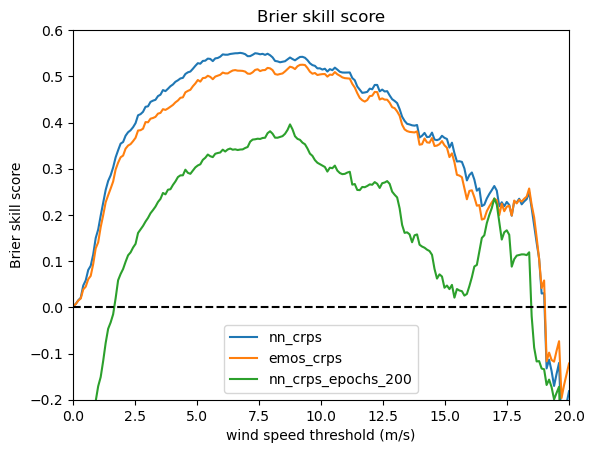

In [18]:
values = np.linspace(0.01, 20, 200)
# values = np.linspace(0.01, 20, 40)
ylim = [-0.2, 0.6]
make_brier_skill_plot_tf(climatology, models, test_data, values, ylim=ylim)

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


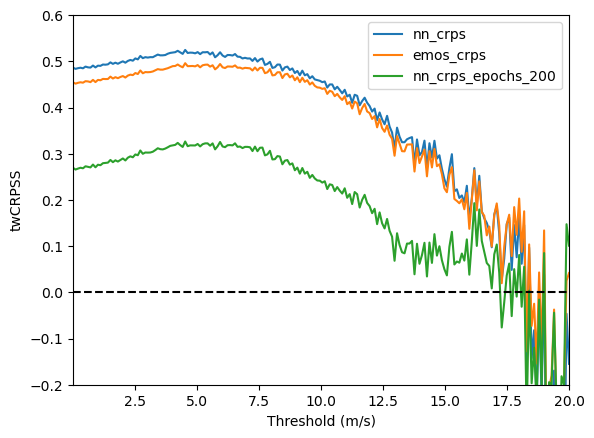

In [19]:
sample_size = 1000
ylim = [-0.2, 0.6]
make_twcrpss_plot_tf(climatology, models, test_data, values, ylim=ylim, sample_size=sample_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


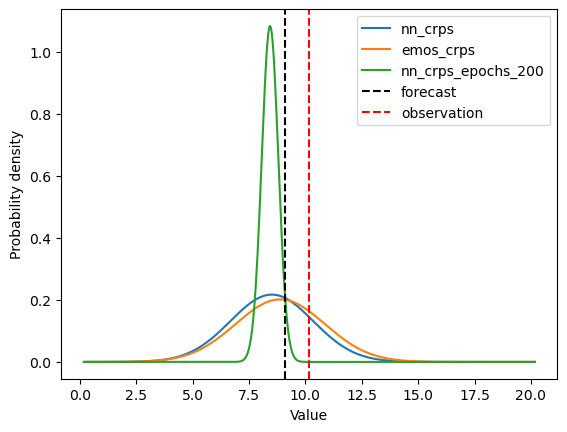

In [28]:
t = 10
plot_forecast_pdf_tf(models, test_data_original, observation_value=t, plot_size= 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


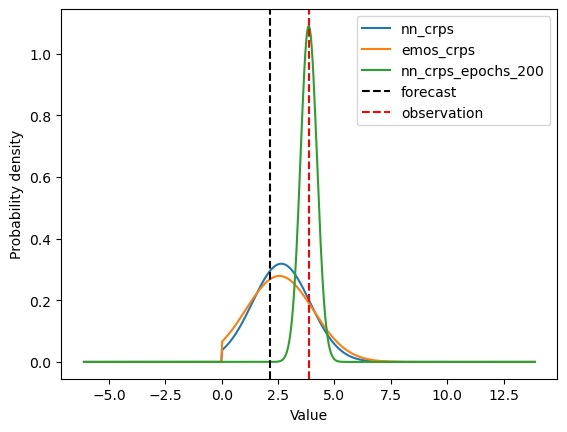

In [27]:
t = 0
plot_forecast_pdf_tf(models, train_data_original, observation_value=t, plot_size= 10)

In [21]:
print('CRPS of nn_crps:', nn_crps.CRPS(test_data, 10000).numpy())
print('CRPS of nn_crps for all samples greater than 17:', nn_crps.CRPS(test_data_greater_17, 10000).numpy())
print('CRPS of climatology: ', climatology.CRPS(test_data, 10000))
print('CRPS of climatology for all samples greater than 17:', climatology.CRPS(test_data_greater_17, 10000))
print('CRPS of EMOS with linear regression: ', emos_crps.CRPS(test_data, 10000).numpy())
print('CRPS of EMOS with linear regression for all samples greater than 17:', emos_crps.CRPS(test_data_greater_17, 10000).numpy())


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
CRPS of nn_crps: 0.8375978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
CRPS of nn_crps for all samples greater than 17: 2.0244784
CRPS of climatology:  1.6289418946304652
CRPS of climatology for all samples greater than 17: 8.93641393099754
CRPS of EMOS with linear regression:  0.88842225
CRPS of EMOS with linear regression for all samples greater than 17: 2.1568372


In [25]:
print("twCRPS18 of nn_crps: ", nn_crps.twCRPS(test_data, [18], 10000)[0].numpy())
print("twCRPS18 of nn_crps for all samples greater than 17: ", nn_crps.twCRPS(test_data_greater_17, [18], 10000)[0].numpy())
print("twCRPS18 of climatology: ", climatology.get_twCRPS(test_data, [18], 10000)[0])
print("twCRPS18 of climatology for all samples greater than 17: ", climatology.get_twCRPS(test_data_greater_17, [18], 10000)[0])

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
twCRPS18 of nn_crps:  0.0023860051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
twCRPS18 of nn_crps for all samples greater than 17:  0.47702315
twCRPS18 of climatology:  0.002585831553044527
twCRPS18 of climatology for all samples greater than 17:  0.6342128004650412
